In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score, davies_bouldin_score

In [150]:
import random
import math

class VKMeans:
    def __init__(self, n_clusters, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = []
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        # Initialize centroids randomly
        self.centroids = random.sample(X, self.n_clusters)

        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]

            # Assign each data point to the nearest centroid
            for point in X:
                closest_centroid_index = self._closest_centroid_index(point)
                clusters[closest_centroid_index].append(point)

            # Update centroids to the mean of their assigned points
            old_centroids = self.centroids.copy()
            for i in range(self.n_clusters):
                if clusters[i]:
                    self.centroids[i] = self._calculate_mean(clusters[i])

            # Check for convergence
            if self._centroids_converged(old_centroids, self.centroids):
                break

        # Calculate inertia
        self.inertia_ = self._calculate_inertia(X)

        # Assign labels
        self.labels_ = self.predict(X)

    def predict(self, X):
        labels = []
        for point in X:
            closest_centroid_index = self._closest_centroid_index(point)
            labels.append(closest_centroid_index)
        return labels

    def _closest_centroid_index(self, point):
        min_distance = float('inf')
        closest_centroid_index = None
        for i, centroid in enumerate(self.centroids):
            distance = self._euclidean_distance(point, centroid)
            if distance < min_distance:
                min_distance = distance
                closest_centroid_index = i
        return closest_centroid_index

    def _euclidean_distance(self, point1, point2):
        return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

    def _calculate_mean(self, points):
        n_dimensions = len(points[0])
        mean = [0] * n_dimensions
        for point in points:
            for i in range(n_dimensions):
                mean[i] += point[i]
        mean = [coord / len(points) for coord in mean]
        return mean

    def _centroids_converged(self, centroids1, centroids2, tol=1e-6):
        for c1, c2 in zip(centroids1, centroids2):
            if self._euclidean_distance(c1, c2) > tol:
                return False
        return True

    def _calculate_inertia(self, X):
        total_inertia = 0
        for point in X:
            closest_centroid_index = self._closest_centroid_index(point)
            closest_centroid = self.centroids[closest_centroid_index]
            total_inertia += self._euclidean_distance(point, closest_centroid) ** 2
        return total_inertia


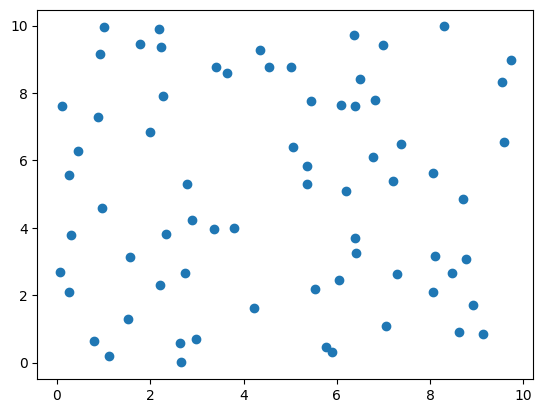

In [151]:
# Generate fake training and test data
random.seed(42)
X_train = [random.uniform(0, 10) for _ in range(50)]
Y_train = [random.uniform(0, 10) for _ in range(50)]

X_test = [random.uniform(0, 10) for _ in range(20)]
Y_test = [random.uniform(0, 10) for _ in range(20)]

x = [*X_train,*X_test]
y = [*Y_train,*Y_test]
plt.scatter(x, y)
plt.show()

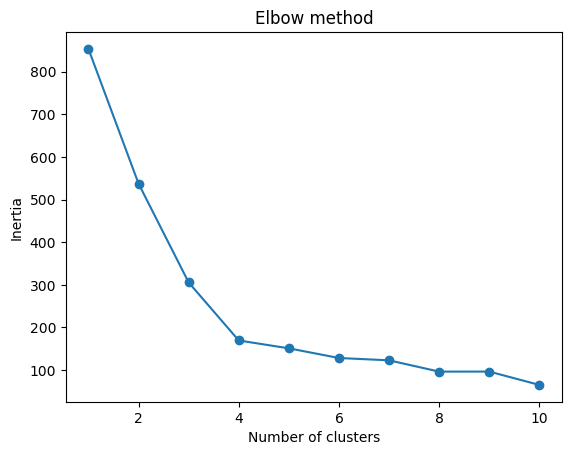

In [152]:
# GridSearch for k
# Combine X and Y coordinates into a list of points for training and test data
data_train = list(zip(X_train, Y_train))

inertias = []

for i in range(1,11):
    kmeans = VKMeans(n_clusters=i)
    kmeans.fit(data_train)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

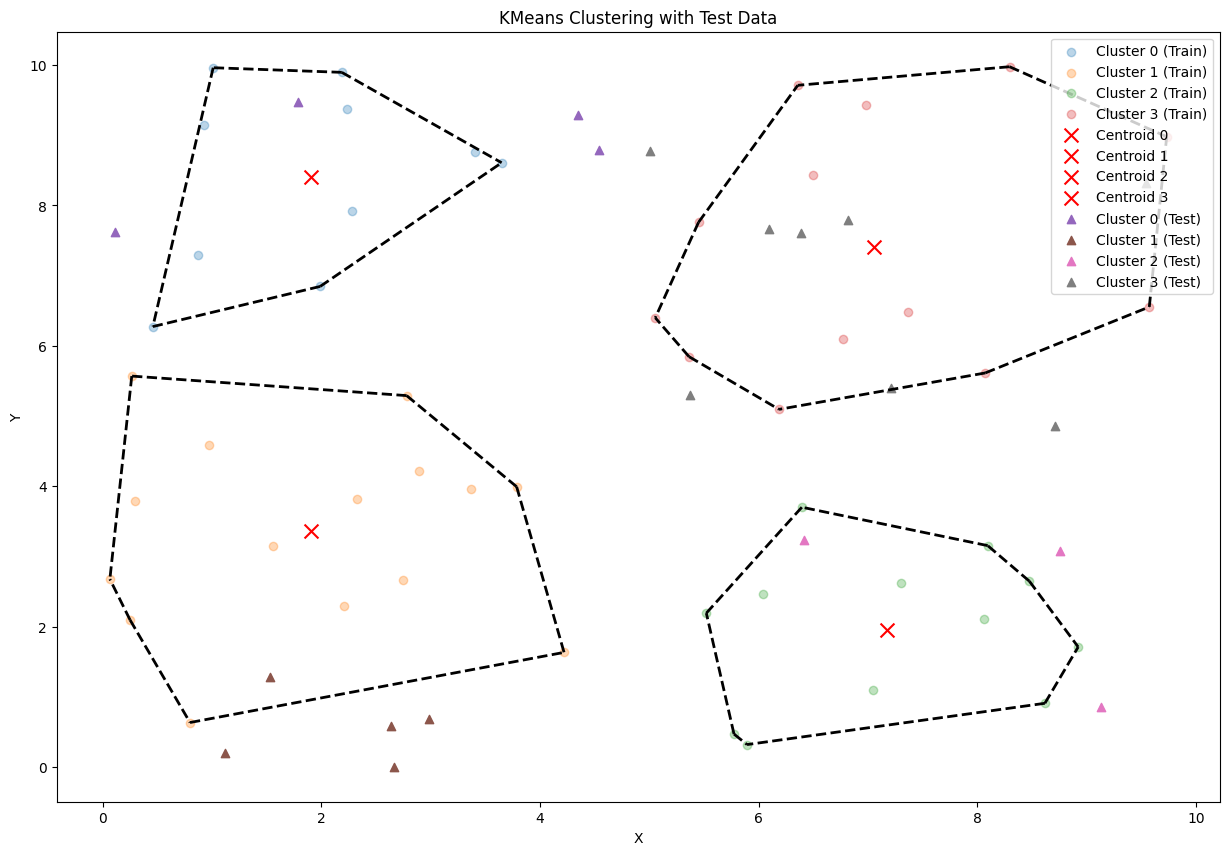

In [153]:
n_clusters = 4
# Instantiate KMeans object
kmeans = VKMeans(n_clusters=n_clusters)

# Fit the model to the training data
kmeans.fit(data_train)

# Get cluster labels for the training data
labels_train = kmeans.labels_

# Get cluster centroids
centroids = kmeans.centroids

# Plot clusters with training data
plt.figure(figsize=(15, 10))
for i in range(kmeans.n_clusters):
    cluster_points = np.array([data_train[j] for j in range(len(data_train)) if labels_train[j] == i])
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i} (Train)', alpha=0.3)

    # Compute convex hull
    hull = ConvexHull(cluster_points)
    for simplex in hull.simplices:
        plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k--', linewidth=2)

# Plot centroids
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {i}')

# Predict clusters for the test data
data_test = list(zip(X_test, Y_test))
labels_test = kmeans.predict(data_test)

# Plot test data with predicted clusters
for i in range(kmeans.n_clusters):
    cluster_points_test = np.array([data_test[j] for j in range(len(data_test)) if labels_test[j] == i])
    plt.scatter(cluster_points_test[:, 0], cluster_points_test[:, 1], label=f'Cluster {i} (Test)', marker='^')

    # Add labels for test data points
    # for point in cluster_points_test:
    #     plt.text(point[0], point[1], f'Cluster {i}', fontsize=8)
plt.title('KMeans Clustering with Test Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()



In [176]:
true_labels_test = [i for i in range(1,n_clusters+1)] * (len(data_test) // n_clusters)  # Assuming equal number of test points in each cluster
true_labels_test

[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]

In [190]:
def precision_ratio(labels_test, true_labels):
    correct_predictions = sum(1 for label_pred, label_true in zip(labels_test, true_labels) if label_pred == label_true)
    total_predictions = len(labels_test)
    precision = correct_predictions / total_predictions
    return precision

In [191]:
ratio = precision_ratio(labels_test, true_labels_test)
print("Partion ratio:", ratio)

Partion ratio: 0.25


In [185]:
len(labels_test) == len(Y_test)

True

In [158]:
# Calculate silhouette score
#The silhouette score ranges from -1 to 1. Higher silhouette scores indicate that the clusters are well-separated
silhouette = silhouette_score(data_test, labels_test)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.43113454765682846


In [159]:
# Calculate Davies-Bouldin index
#Lower Davies-Bouldin index values indicate better clustering
davies_bouldin = davies_bouldin_score(data_test, labels_test)
print("Davies-Bouldin Index:", davies_bouldin)

Davies-Bouldin Index: 0.687072344520731
